# Telco customer churn

Built a machine learning classification model to predict if a customer wiil churn in a telco company.

Imported the neccesary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

Loaded the dataset and saw the first 5 rows.

In [2]:
df=pd.read_csv('Telco customer churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


The dataset have numerical and categorical features. It has no missing values.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


The classes of the dataset are imbalanced. We have 27% of churn and 73% of no churn.

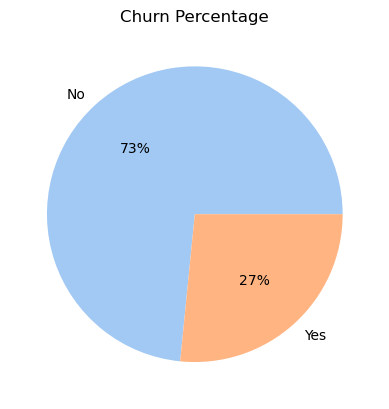

In [4]:
#define Seaborn color palette to use
colors = sns.color_palette('pastel')

#create pie chart
plt.pie(df.groupby('Churn').size().reset_index()[0],labels=['No', 'Yes'],colors = colors, autopct='%.0f%%')
plt.title('Churn Percentage')
plt.show()

The users with dependants are less likely to churn with a 16%.

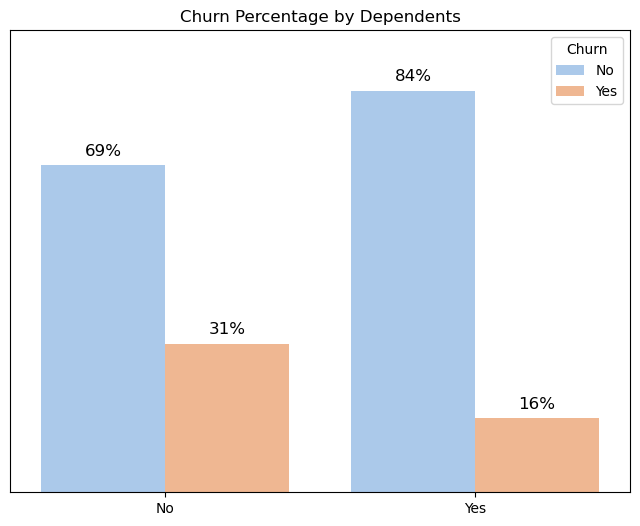

In [5]:
# Calculate the percentages
dependents_churn_percent = df.groupby(['Dependents', 'Churn']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).reset_index()
dependents_churn_percent.columns = ['Dependents', 'Churn', 'percentage']

# Set the style and color palette
sns.set_palette('pastel')

# Create the bar chart
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Dependents', y='percentage', hue='Churn', data=dependents_churn_percent)

# Add percentage labels on top of each bar
for p in ax.patches:
    ax.annotate(f"{p.get_height():.0f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 5),
                 textcoords='offset points')

ax.set_ylim(0, max(dependents_churn_percent['percentage']) * 1.15)
ax.set(ylabel=None)
ax.set(xlabel=None)
ax.set(yticklabels=[]) 
ax.tick_params(left=False) 
plt.title('Churn Percentage by Dependents')
plt.show()

The senior citizens are more likely to churn with a 42%.

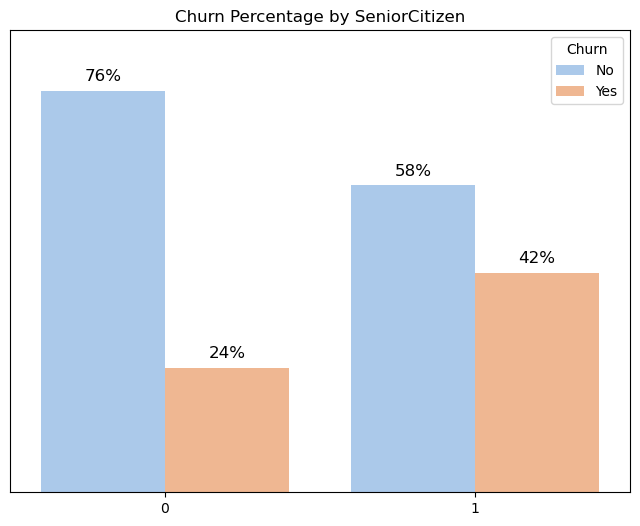

In [6]:
# Calculate the percentages
senior_citizen_churn_percent = df.groupby(['SeniorCitizen', 'Churn']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).reset_index()
senior_citizen_churn_percent.columns = ['SeniorCitizen', 'Churn', 'percentage']

# Set the style and color palette
sns.set_palette('pastel')

# Create the bar chart
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='SeniorCitizen', y='percentage', hue='Churn', data=senior_citizen_churn_percent)

# Add percentage labels on top of each bar
for p in ax.patches:
    ax.annotate(f"{p.get_height():.0f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 5),
                 textcoords='offset points')

ax.set_ylim(0, max(senior_citizen_churn_percent['percentage']) * 1.15)
ax.set(ylabel=None)
ax.set(xlabel=None)
ax.set(yticklabels=[]) 
ax.tick_params(left=False) 
plt.title('Churn Percentage by SeniorCitizen')
plt.show()

To train the models changed the churn column to be numeric.

In [7]:
df['Churn_number']=np.where(df['Churn']=='Yes',1,0)

Defined the features and target for the models. Used get_dummies to transform the categorical features to numeric.

In [8]:
X = df.drop(['customerID','Churn', 'Churn_number'], axis = 1)
X=pd.get_dummies(X, drop_first=True)
y=df['Churn_number']

Created a function that trains different models and creates a table comparing the f1 score of each one.

In [9]:
def compare_models(X, y, n_splits=5):
    
    # Define models
    models = {
        'XGBoost': XGBClassifier(random_state=0),
        'Random Forest': RandomForestClassifier(random_state=0),
        'SVM': SVC(random_state=0)
    }
    
    # Perform Stratified K-Fold cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Train models and calculate F1 scores
    results = []
    for name, model in models.items():
        f1_scores = []
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            # Apply StandardScaler
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            f1 = f1_score(y_test, y_pred, average='weighted')
            f1_scores.append(f1)
        results.append({'Model': name, 'Average F1 Score': round(sum(f1_scores) / len(f1_scores),4)})
    
    # Convert results to a pandas DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

The f1 score of the 3 models were very similar. The SVM had the best f1 score with 0.7859

In [10]:
results = compare_models(X, y)
results

,Model,Average F1 Score
0,XGBoost,0.7806
1,Random Forest,0.7856
2,SVM,0.7859
